# s_default_probabilities

In this script we consider a set of classifiers and choose the best one via cross-validation <u><a style="color:#3c9591" href="https://www.arpm.co/lab/redirect.php?permalink=default-case-study">(Read more).</a></u>

In [4]:
from numpy import abs, arange, array, clip, concatenate, log, mean, min, r_, sum, where
from scipy.special import logit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, QuantileTransformer
from sklearn.metrics import auc, confusion_matrix, roc_curve
from pandas import read_csv
from seaborn import barplot, histplot, lineplot
from matplotlib.pyplot import show

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">Load data</h1>

From <a style="color:#3c9591" href="../../../Databases/global-databases/credit/db_default_data_creditcardsclients/db_default_data_creditcardsclients.csv">db_default_data_creditcardsclients</a> database, we upload categorical features and exclude client ID. We then preprocess the data into features and labels, standardize and transform features, and define test and estimation sets.

In [6]:
################## input (you can change it) ##################
n_sample = 10000  #  number of samples in database (max 30000)
###############################################################

db_creditcardsclients = read_csv('/Users/anugrahkumarsingh/Downloads/Projects/Credit Default - ML/db_default_data_creditcardsclients.csv')
db_creditcardsclients = db_creditcardsclients.iloc[:, 1:db_creditcardsclients.shape[1]]  # exlude client id
# sort database so that categorical features are at beginning
ind_cat = r_[arange(1, 4), arange(5, 11)]  # indices of categorical features
n_cat = len(ind_cat)  # number of categorical features
ind_cont = r_[array([0, 4]), arange(11, db_creditcardsclients.shape[1])]  # indices of continuous features
n_cont = len(ind_cont)  # number of continuous features
db_creditcardsclients = db_creditcardsclients.iloc[:n_sample, r_[ind_cat, ind_cont]]
# outputs and features
z = array(db_creditcardsclients.iloc[:, :-1])  # features
x = array(db_creditcardsclients.iloc[:, -1])  # labels
# standardize continuous features
quantile_transformer = QuantileTransformer(output_distribution='normal')
z_cont = quantile_transformer.fit_transform(z[:, -n_cont:])
# transform categorical features via one-hot encoding
enc = OneHotEncoder(categories='auto')
# shift up, because OneHotEncoder takes only positive inputs
z_cat = enc.fit_transform(abs(min(z[:, :n_cat], axis=0)) + z[:, :n_cat]).toarray()
z = concatenate((z_cat, z_cont), axis=1)  # feature matrix

z_estimation, z_test, x_estimation, x_test = train_test_split(z, x)  # define test set and estimation set

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">1. Default prediction: logistic regression
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=exam-crdiasc-copy-4">(Read more)</a></u>

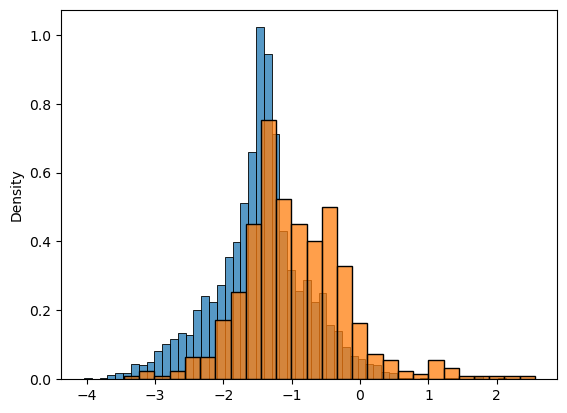

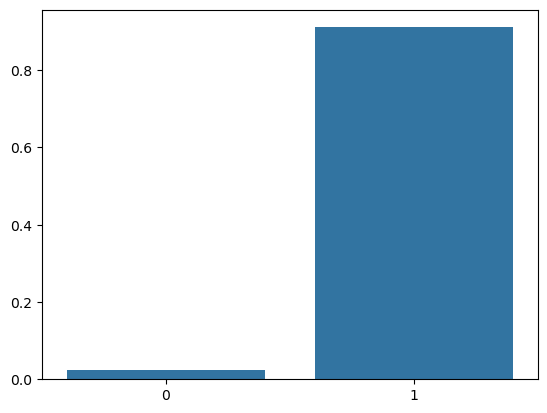

In [8]:
# define model
model_lg_c = LogisticRegression(penalty=None, solver='lbfgs', max_iter=20000)
model_lg_c = model_lg_c.fit(z_estimation[:, -n_cont:], x_estimation)  # fit model
p_z_lg_c = model_lg_c.predict_proba(z_test[:, -n_cont:])[:, 1]  # predict probs
cm_lg_c = confusion_matrix(x_test, model_lg_c.predict(z_test[:, -n_cont:]))  # confusion matrix

# conditional scores
s_0_lg_c = logit(model_lg_c.predict_proba(z_test[:, -n_cont:])[where(x_test == 0)[0], 1])
s_1_lg_c = logit(model_lg_c.predict_proba(z_test[:, -n_cont:])[where(x_test == 1)[0], 1])

##################################### plots #####################################
# scores
histplot(x=s_0_lg_c, stat='density')
histplot(x=s_1_lg_c, stat='density'); show();

# confusion matrix
barplot(x=[0,1], y=[cm_lg_c[0,1]/sum(x_test == 0),cm_lg_c[1,0]/sum(x_test == 1)]);

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">2. Default prediction: logistic regression with interactions
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=exam-crdiasc-copy-4a">(Read more)</a></u>

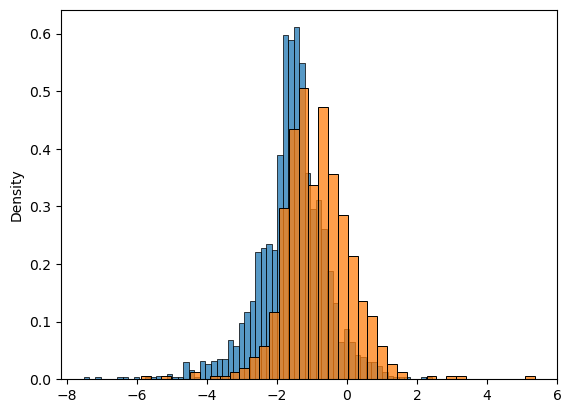

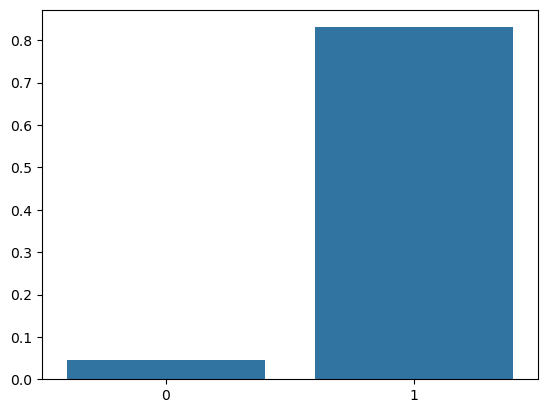

In [10]:
########## input (you can change it) ###########
pol_degree = 2  # degrees in polynomial features
################################################

# add interactions
poly = PolynomialFeatures(degree=pol_degree)
z_estimation_inter = poly.fit_transform(z_estimation[:, -n_cont:])
z_test_inter = poly.fit_transform(z_test[:, -n_cont:])

# define model (set C=+infinity to have 0 lasso parameter)
model_lg_c_quad = LogisticRegression(penalty='l2', C=1000000000, solver='lbfgs', max_iter=8000)
model_lg_c_quad = model_lg_c_quad.fit(z_estimation_inter, x_estimation)  # fit model
p_z_lg_c_quad = model_lg_c_quad.predict_proba(z_test_inter)[:, 1]  # predict probs
cm_lg_c_quad = confusion_matrix(x_test, model_lg_c_quad.predict(z_test_inter))  # confusion matrix

# conditional scores
s_0_lg_c_quad = logit(model_lg_c_quad.predict_proba(z_test_inter)[where(x_test == 0)[0], 1])
s_1_lg_c_quad = logit(model_lg_c_quad.predict_proba(z_test_inter)[where(x_test == 1)[0], 1])

########################################## plots ##########################################
# scores
histplot(x=s_0_lg_c_quad, stat='density')
histplot(x=s_1_lg_c_quad, stat='density'); show();

# confusion matrix
barplot(x=[0,1], y=[cm_lg_c_quad[0,1]/sum(x_test == 0),cm_lg_c_quad[1,0]/sum(x_test == 1)]);

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">3. Default prediction: logistic regression with interactions and categorical features
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=exam-crdiasc-copy-4cat">(Read more)</a></u>

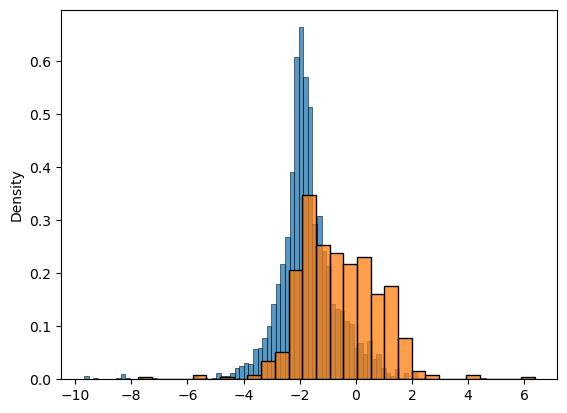

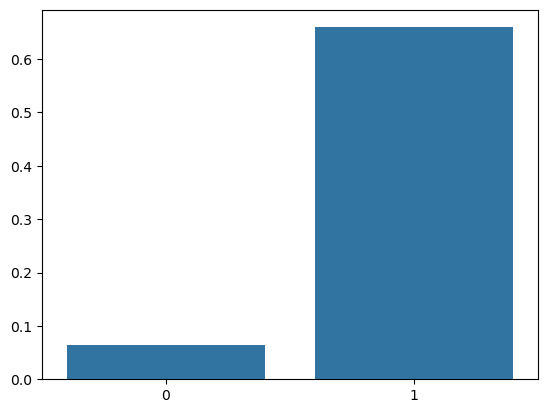

In [12]:
n_lg_quad = z_cat.shape[1]  # number of encoded categorical features

z_lg_quad_estimation = concatenate((z_estimation[:, :n_lg_quad], z_estimation_inter), axis=1)
z_lg_quad_test = concatenate((z_test[:, :n_lg_quad], z_test_inter), axis=1)

# define model (set C=+infinity to have 0 lasso parameter)
model_lg_quad = LogisticRegression(penalty='l2', C=1000000000, solver='lbfgs', max_iter=20000)
model_lg_quad = model_lg_quad.fit(z_lg_quad_estimation, x_estimation)  # fit model
p_z_lg_quad = model_lg_quad.predict_proba(z_lg_quad_test)[:, 1]  # predict probs
cm_lg_quad = confusion_matrix(x_test, model_lg_quad.predict(z_lg_quad_test))  # confusion matrix

# conditional scores
s_0_lg_quad = logit(model_lg_quad.predict_proba(z_lg_quad_test)[where(x_test == 0)[0], 1])
s_1_lg_quad = logit(model_lg_quad.predict_proba(z_lg_quad_test)[where(x_test == 1)[0], 1])

######################################## plots ########################################
# scores
histplot(x=s_0_lg_quad, stat='density')
histplot(x=s_1_lg_quad, stat='density'); show();

# confusion matrix
barplot(x=[0,1], y=[cm_lg_quad[0,1]/sum(x_test == 0),cm_lg_quad[1,0]/sum(x_test == 1)]);

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">4. Default prediction: logistic regression with lasso
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=examp-opcsas-copy-7">(Read more)</a></u>

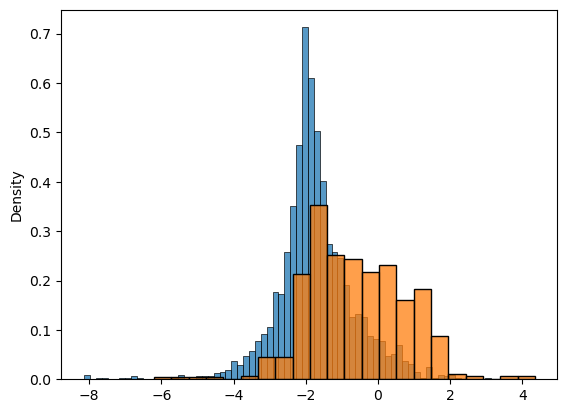

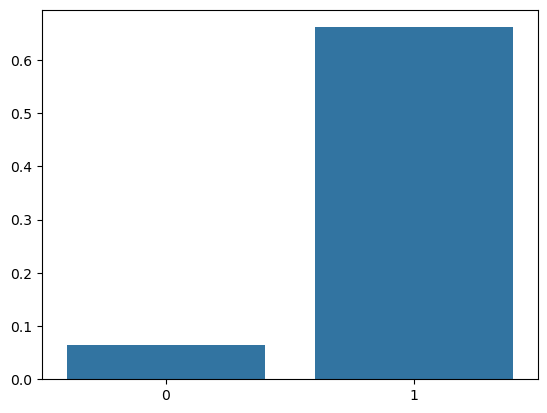

In [14]:
########## input (you can change it) ##########
lambda_lasso = 0.05  # lasso parameter
###############################################

model_lg_lasso = LogisticRegression(penalty='l1', C=1/lambda_lasso, solver='liblinear', max_iter=500)  # method
model_lg_lasso = model_lg_lasso.fit(z_lg_quad_estimation, x_estimation)  # fit model
p_z_lg_lasso = model_lg_lasso.predict_proba(z_lg_quad_test)[:, 1]  # predict probs
cm_lg_lasso = confusion_matrix(x_test, model_lg_lasso.predict(z_lg_quad_test))  # confusion matrix

# conditional scores
s_0_lg_lasso = logit(model_lg_lasso.predict_proba(z_lg_quad_test)[where(x_test == 0)[0], 1])
s_1_lg_lasso = logit(model_lg_lasso.predict_proba(z_lg_quad_test)[where(x_test == 1)[0], 1])

######################################### plots #########################################
# scores
histplot(x=s_0_lg_lasso, stat='density')
histplot(x=s_1_lg_lasso, stat='density'); show();

# confusion matrix
barplot(x=[0,1], y=[cm_lg_lasso[0,1]/sum(x_test == 0),cm_lg_lasso[1,0]/sum(x_test == 1)]);

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">5. Default prediction: CART
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=examp-opcsas-copy-7tree">(Read more)</a></u>

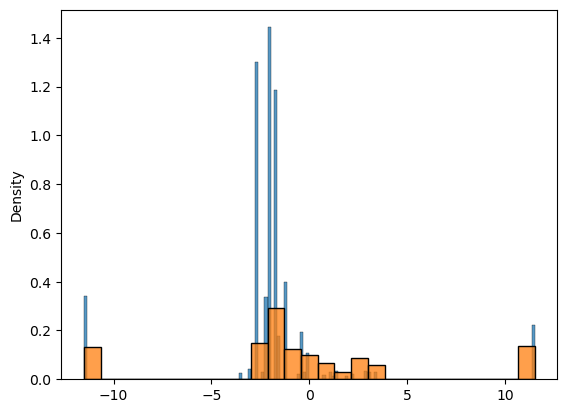

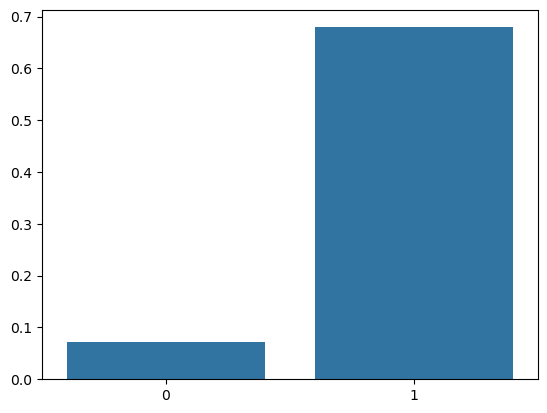

In [16]:
################## input (you can change it) ###################
max_depth_tree = 10  # maximum depth of decision tree classifier
################################################################

model_tree = DecisionTreeClassifier(max_depth=max_depth_tree)  # method (Gini splitting criterion)
model_tree = model_tree.fit(z_lg_quad_estimation, x_estimation)  # fit model
p_z_tree = model_tree.predict_proba(z_lg_quad_test)[:, 1]  # predict scores
cm_tree = confusion_matrix(x_test, model_tree.predict(z_lg_quad_test))  # confusion matrix

# conditional scores
eps = 0.00001  # set threshold to avoid numerical noise in logit function
p_0_tree = model_tree.predict_proba(z_lg_quad_test)[where(x_test == 0)[0], 1]
p_0_tree = clip(p_0_tree, eps, 1 - eps)
p_1_tree = model_tree.predict_proba(z_lg_quad_test)[where(x_test == 1)[0], 1]
p_1_tree = clip(p_1_tree, eps, 1 - eps)
s_0_tree = logit(p_0_tree)
s_1_tree = logit(p_1_tree)

##################################### plots #####################################
# scores
histplot(x=s_0_tree, stat='density')
histplot(x=s_1_tree, stat='density'); show();

# confusion matrix
barplot(x=[0,1], y=[cm_tree[0,1]/sum(x_test == 0),cm_tree[1,0]/sum(x_test == 1)]);

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">6. Default prediction: CART with gradient boosting
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=examp-opcsas-copy-7boost">(Read more)</a></u>

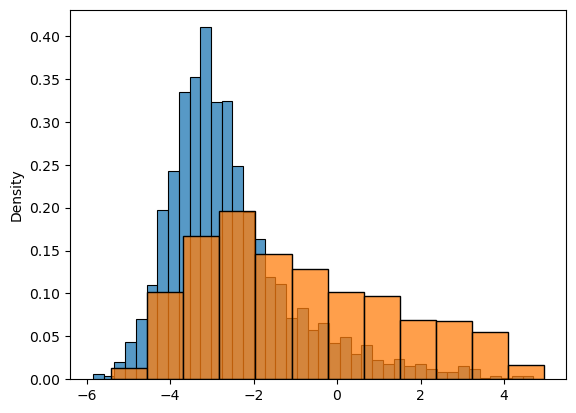

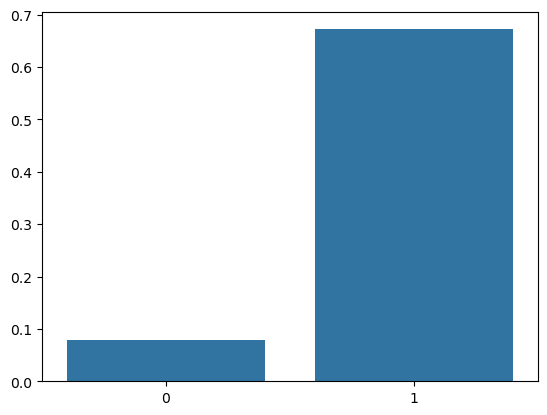

In [18]:
model_tree_boost = GradientBoostingClassifier(max_depth=max_depth_tree)  # method (Gini splitting criterion)
model_tree_boost = model_tree_boost.fit(z_lg_quad_estimation, x_estimation)  # fit model
p_z_tree_boost = model_tree_boost.predict_proba(z_lg_quad_test)[:, 1]  # predict probs
cm_tree_boost = confusion_matrix(x_test, model_tree_boost.predict(z_lg_quad_test))  # confusion matrix

# conditional scores
s_0_tree_boost = logit(model_tree_boost.predict_proba(z_lg_quad_test)[where(x_test == 0)[0], 1])
s_1_tree_boost = logit(model_tree_boost.predict_proba(z_lg_quad_test)[where(x_test == 1)[0], 1])

########################################### plots ###########################################
# scores
histplot(x=s_0_tree_boost, stat='density')
histplot(x=s_1_tree_boost, stat='density'); show();

# confusion matrix
barplot(x=[0,1], y=[cm_tree_boost[0,1]/sum(x_test == 0),cm_tree_boost[1,0]/sum(x_test == 1)]);

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">7. Default prediction: out-of-sample error and AUC
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=examp-errors-credit">(Read more)</a></u>

model = logistic
error = 1.63
AUC = 0.69


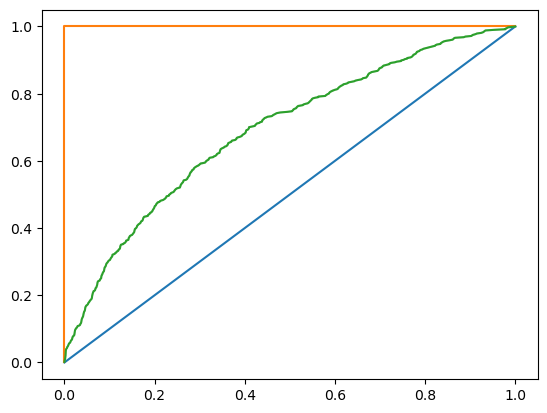

In [20]:
######################################### input (you can change it) #########################################
choose_model = 'logistic' # logistic? logistic with interactions? logistic with interactions and categorical?
                          # logistic with lasso? CART? or gradient boosting?
#############################################################################################################

if choose_model == 'logistic':
    er = -sum(log(p_z_lg_c[p_z_lg_c>0]))/len(p_z_lg_c[p_z_lg_c>0])  # error
    fpr, tpr, _ = roc_curve(x_test, p_z_lg_c)
    
elif choose_model == 'logistic with interactions':
    er = -sum(log(p_z_lg_c_quad[p_z_lg_c_quad>0]))/len(p_z_lg_c_quad[p_z_lg_c_quad>0])  # error
    fpr, tpr, _ = roc_curve(x_test, p_z_lg_c_quad)

elif choose_model == 'logistic with interactions and categorical':
    er = -sum(log(p_z_lg_quad[p_z_lg_quad>0]))/len(p_z_lg_quad[p_z_lg_quad>0])  # error
    fpr, tpr, _ = roc_curve(x_test, p_z_lg_quad)

elif choose_model == 'logistic with lasso':
    er = -sum(log(p_z_lg_lasso[p_z_lg_lasso>0]))/len(p_z_lg_lasso[p_z_lg_lasso>0])  # error
    fpr, tpr, _ = roc_curve(x_test, p_z_lg_lasso)

elif choose_model == 'CART':
    er = -sum(log(p_z_tree[p_z_tree>0]))/len(p_z_tree[p_z_tree>0])  # error
    fpr, tpr, _ = roc_curve(x_test, p_z_tree)

elif choose_model == 'gradient boosting':
    er = -sum(log(p_z_tree_boost[p_z_tree_boost>0]))/len(p_z_tree_boost[p_z_tree_boost>0])  # error
    fpr, tpr, _ = roc_curve(x_test, p_z_tree_boost)
    
auc = auc(fpr, tpr)  # auc on test set
print('model =', choose_model)
print('error =', er.round(2))
print('AUC =', auc.round(3))

###################### plot ######################
# out-of-sample ROC curve
lineplot(x=[0, 1], y=[0, 1])
lineplot(x=[0, 0, 1], y=[0, 1, 1], estimator=None)
lineplot(x=fpr, y=tpr);

<h1 style="font-weight: bold; font-size:14px; line-height:1.5em;">8. Default prediction: cross-validation
<u><a style="color:#3c9591; font-weight: normal" href="https://www.arpm.co/lab/redirect.php?permalink=examp-opcsas-copy-crossval">(Read more)</a></u>

In [22]:
######################## inputs (you can change them) ########################
cross_val = 1  # set "1" to do cross-validation (computational time increases)
k_bar = 5  # parameter of Stratified K-Folds cross-validator
##############################################################################

if cross_val == 1:
    # split estimation set into training and validation sets for k-fold cross-validation
    k_fold = StratifiedKFold(n_splits=k_bar)
    # function to split data into train and validation sets
    def split_data(k_fold, z, x):
        train_sets = []
        val_sets = []
        for train, val in k_fold.split(z, x):
            train_sets.append(z[train])
            val_sets.append(z[val])
        return train_sets, val_sets
    # split estimation data
    z_train, z_val = split_data(k_fold, z_estimation, x_estimation)
    z_train_inter, z_val_inter = split_data(k_fold, z_estimation_inter, x_estimation)
    z_train_lg_quad, z_val_quad = split_data(k_fold, z_lg_quad_estimation, x_estimation)
    # split x data
    x_train = [x_estimation[train] for train, _ in k_fold.split(z_estimation, x_estimation)]
    x_val = [x_estimation[val] for _, val in k_fold.split(z_estimation, x_estimation)]
    cv_er = []
    if choose_model == 'logistic':
        for k in range(k_bar):
            p_cv = model_lg_c.fit(z_train[k], x_train[k]).predict_proba(z_val[k])
            cv_er.append(-sum(log(p_cv[p_cv>0]))/len(p_cv[p_cv>0]))
            
    elif choose_model == 'logistic with interactions':
        for k in range(k_bar):
            p_cv = model_lg_c_quad.fit(z_train_inter[k], x_train[k]).predict_proba(z_val_inter[k])
            cv_er.append(-sum(log(p_cv[p_cv>0]))/len(p_cv[p_cv>0]))
            
    elif choose_model == 'logistic with interactions and categorical':
        for k in range(k_bar):
            p_cv = model_lg_quad.fit(z_train_lg_quad[k], x_train[k]).predict_proba(z_val_quad[k])
            cv_er.append(-sum(log(p_cv[p_cv>0]))/len(p_cv[p_cv>0]))

    elif choose_model == 'logistic with lasso':
        for k in range(k_bar):
            p_cv = model_lg_lasso.fit(z_train[k], x_train[k]).predict_proba(z_val[k])
            cv_er.append(-sum(log(p_cv[p_cv>0]))/len(p_cv[p_cv>0])) 
        
    elif choose_model == 'CART':
        for k in range(k_bar):
            p_cv = model_lg_quad.fit(z_train_lg_quad[k], x_train[k]).predict_proba(z_val_quad[k])
            cv_er.append(-sum(log(p_cv[p_cv>0]))/len(p_cv[p_cv>0]))
   
    elif choose_model == 'gradient boosting':
        for k in range(k_bar):
            p_cv = model_lg_quad.fit(z_train_lg_quad[k], x_train[k]).predict_proba(z_val_quad[k])
            cv_er.append(-sum(log(p_cv[p_cv>0]))/len(p_cv[p_cv>0]))
    print('model =', choose_model)
    print('cv_er =', round(mean(cv_er), 3))

model = logistic
cv_er = 1.051
